In [64]:
# Load packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [65]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_wrds'

# set path as working directory:
os.chdir(path)

In [66]:
# load fredgraph data:
aggregates = pd.read_csv('fredgraph.csv')

# rename some variables
aggregates.rename(columns = {'DATE':'Date', 
                             'NGDPSAXDCUSQ': 'Nominal GDP', 
                             'GDPDEF': 'Deflator'}, inplace = True)

# drop the first row:
aggregates = aggregates.iloc[1:,:]

# for all entries with '.' substitute with NaN:
aggregates = aggregates.replace('.', np.nan)

# make 'Deflator' and 'Nominal GDP' floats:
aggregates['Deflator'] = aggregates['Deflator'].astype(float)
aggregates['Nominal GDP'] = aggregates['Nominal GDP'].astype(float)

# make 'Date' a datetime object:
aggregates['Date'] = pd.to_datetime(aggregates['Date'])

# create 'Real GDP' variable:
aggregates['Real GDP'] = aggregates['Nominal GDP'] / aggregates['Deflator']

# adjust the FF rate: 
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'] / 100
aggregates['Date'] = aggregates['Date'] - pd.DateOffset(days = 1)

# compute the growth rate of Nominal GDP and the Deflator:
aggregates['Growth Rate Nominal GDP'] = aggregates['Nominal GDP'].pct_change(fill_method=None)
aggregates['Growth Rate Deflator'] = aggregates['Deflator'].pct_change(fill_method=None)

# compute the growth rate of Real GDP by subtracting the growth rate of the Deflator from the growth rate of Nominal GDP:
aggregates['Growth Rate Real GDP'] = aggregates['Growth Rate Nominal GDP'] - aggregates['Growth Rate Deflator']

In [ ]:
# load call reports data:
loans = pd.read_csv('loans_balanced_panel.csv', low_memory=False)
int_income = pd.read_csv('interest_income_balanced.csv', low_memory=False)

# merge the datasets
df = pd.merge(loans[['Date', 'IDRSSD', 'RCON2122', 'Flag']], int_income, 
              on=['IDRSSD', 'Date'], how='outer', suffixes=('_RCON', '_RIAD'))

# adjust the dates
df['Date'] = pd.to_datetime(df['Date'])

# create a 'Flag' that is zero if both are zero, and 1 if either is 1:
df['Flag'] = np.where(df['Flag_RCON'] + df['Flag_RIAD'] > 0, 1, 0)

# drop the two flag columns:
df = df.drop(columns=['Flag_RCON', 'Flag_RIAD'])

# create an 'Agg. Loans' summing all the loans in a given Date:
df['Agg. Loans'] = df.groupby('Date')['RCON2122'].transform('sum')

In [72]:
# merge df with aggregates:
df = pd.merge(df[['Date', 'IDRSSD', 'Agg. Loans', 'RCON2122', 
                  'Int. Income Loans']], aggregates[['Date', 'FEDFUNDS', 'Real GDP', 'Deflator']], on='Date', how='left')

# create 'Agg. Real Loans':
df['Agg. Real Loans'] = df['Agg. Loans'] / df['Deflator']

In [ ]:
# create a 'Time' variable grouping 'Dates':
df['Time'] = df.groupby('Date').ngroup()

# run regressions to detrend variables of interest 
df['De-trended Real Loans'] = sm.OLS(np.log(df['Agg. Real Loans']), sm.add_constant(df['Time'])).fit().resid
df['De-trended Real GDP'] = sm.OLS(np.log(df['Real GDP']), sm.add_constant(df['Time'])).fit().resid

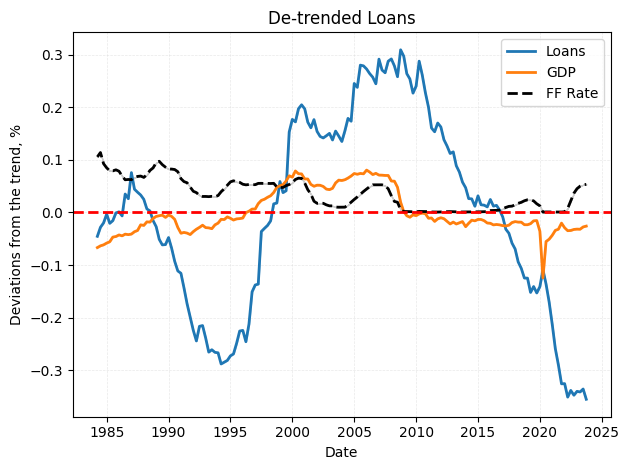

In [77]:
# plot the de-trended loans using seaborn:
sns.lineplot(x='Date', y='De-trended Real Loans', data=df, linewidth=2, label='Loans')
sns.lineplot(x='Date', y='De-trended Real GDP', data=df, linewidth=2, label='GDP')
sns.lineplot(x='Date', y='FEDFUNDS', data=df, linewidth=2, label='FF Rate', color='black', linestyle='--')
# add a line at zero:
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('De-trended Loans')
plt.xlabel('Date')
plt.ylabel('Deviations from the trend, %')
plt.legend()
plt.tight_layout()
# add the grids:
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()